In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [3]:
df = pd.read_csv('oil_spill.csv')
df

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,target
0,1,2558,1506.09,456.63,90,6395000,40.88,7.89,29780.0,0.19,...,2850.00,1000.00,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,2,22325,79.11,841.03,180,55812500,51.11,1.21,61900.0,0.02,...,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,3,115,1449.85,608.43,88,287500,40.42,7.34,3340.0,0.18,...,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
3,4,1201,1562.53,295.65,66,3002500,42.40,7.97,18030.0,0.19,...,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
4,5,312,950.27,440.86,37,780000,41.43,7.03,3350.0,0.17,...,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,200,12,92.42,364.42,135,97200,59.42,10.34,884.0,0.17,...,381.84,254.56,84.85,146.97,4.50,0,2593.50,65.85,6.39,0
933,201,11,98.82,248.64,159,89100,59.64,10.18,831.0,0.17,...,284.60,180.00,150.00,51.96,1.90,0,4361.25,65.70,6.53,0
934,202,14,25.14,428.86,24,113400,60.14,17.94,847.0,0.30,...,402.49,180.00,180.00,0.00,2.24,0,2153.05,65.91,6.12,0
935,203,10,96.00,451.30,68,81000,59.90,15.01,831.0,0.25,...,402.49,180.00,90.00,73.48,4.47,0,2421.43,65.97,6.32,0


In [4]:
X = df.drop('target', axis=1).to_numpy()
y = df['target'].to_numpy()

#normalization
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std

X_train, X_val , y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=10)
X_train.shape

(655, 49)

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca

array([[ 1.00861931e+01,  4.24176229e-02],
       [ 9.86910196e+01,  5.74671500e-02],
       [-8.64563406e-01,  4.26389637e-02],
       ...,
       [-1.17674468e+00, -1.01409544e-02],
       [-1.23483703e+00, -9.64873117e-03],
       [-1.22031334e+00, -7.21476054e-03]])

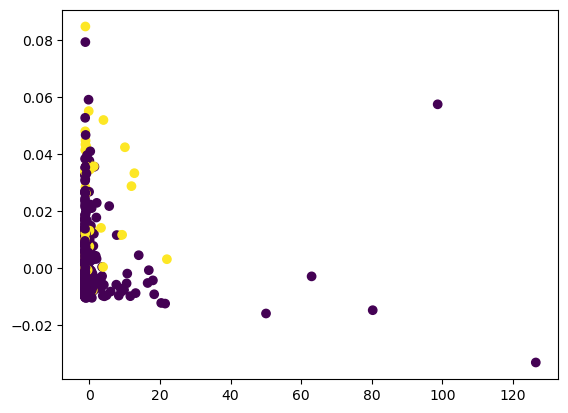

In [6]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

In [8]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(49, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10,1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

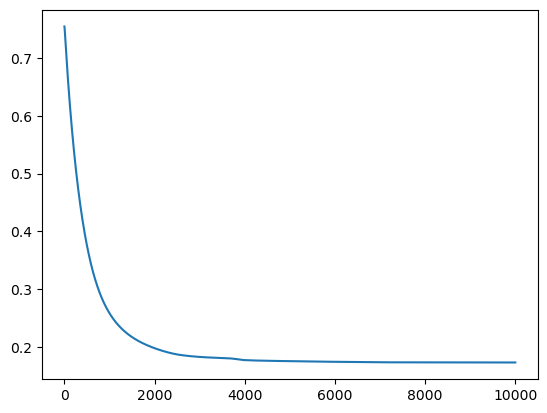

In [9]:
net = NeuralNet()
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.8)
criterion = nn.BCELoss()

epochs = 10000
train_losses = []
for epoch in range(epochs):
    outputs = net(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())    

plt.plot([i for i in range(0, epochs)], train_losses)
plt.show()

In [10]:
train_losses[-1]

0.17314355075359344

In [11]:
net.eval()
total = 0
correct = 0
with torch.no_grad():
    outputs = net(X_val)
    predicted = (outputs > 0.5).squeeze().int()
    total += y_val.size(0)
    correct += (predicted == y_val).sum().item()

# calculate the accuracy
accuracy = correct / total

# print the accuracy
print('Accuracy of the network on validation set: %d %%' % (100 * accuracy))

Accuracy of the network on validation set: 95 %
